<a href="https://colab.research.google.com/github/Boubacar5400/Mon_projet_ML/blob/main/Mon_projet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation des données**

Pour ce faire, nous utilisons le packages yfinance pour extraire les données sur l'indice boursier  S&P500 des USA.

In [2]:
import pandas as pd
import yfinance as yf

# Fonction pour récupérer les données mensuelles du S&P 500
def get_snp500_data(start_date, end_date):
    snp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')
    return snp500_data

# Définir les dates de début et de fin
start_date = '2000-01-01'
end_date = '2024-05-01'

# Récupérer les données du S&P 500
snp500_data = get_snp500_data(start_date, end_date)

# Afficher les premières lignes des données récupérées
print(snp500_data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  
Date                    
2000-01-03   931800000  
2000-01-04  1009000000  
2000-01-05  1085500000  
2000-01-06  1092300000  
2000-01-07  1225200000  


In [3]:
df=snp500_data[['Close']]

In [4]:
df.tail()

,Close
Date,
2024-04-24,5071.629883
2024-04-25,5048.419922
2024-04-26,5099.959961
2024-04-29,5116.169922
2024-04-30,5035.689941


In [5]:
df.head()

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


In [6]:
df.shape

(6120, 1)

In [7]:
df.dtypes

Close    float64
dtype: object

In [8]:
import numpy as np
df.isnull().sum()  # pas de données manquantes

Close    0
dtype: int64

# **Analyse exploratoire des données**

- **Visualisation des données**

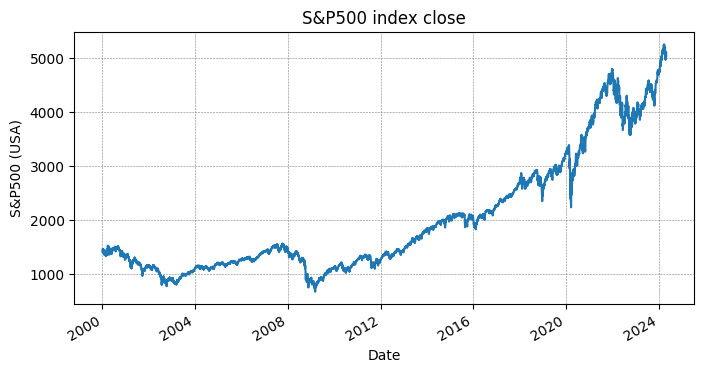

In [9]:
from matplotlib import pyplot as plt
df['Close'].plot(kind='line', figsize=(8, 4), title='S&P500 index close')
plt.xlabel('Date')
plt.ylabel('S&P500 (USA)')
plt.grid(color='gray', linestyle='--', linewidth=0.4)

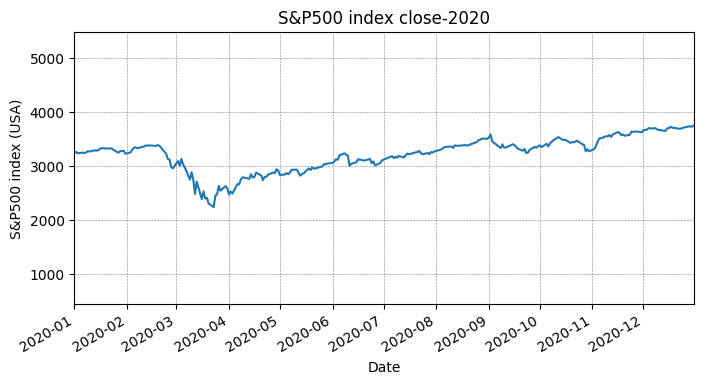

In [10]:
# Tracer le graphique avec toutes les données
df['Close'].plot(kind='line', figsize=(8, 4), title='S&P500 index close-2020')
plt.xlabel('Date')
plt.ylabel('S&P500 index (USA)')
plt.grid(color='gray', linestyle='--', linewidth=0.4)

# Définir les limites de l'axe des x pour l'année 2020
plt.xlim('2020-01-01', '2020-12-31')

# Afficher le graphique
plt.show()

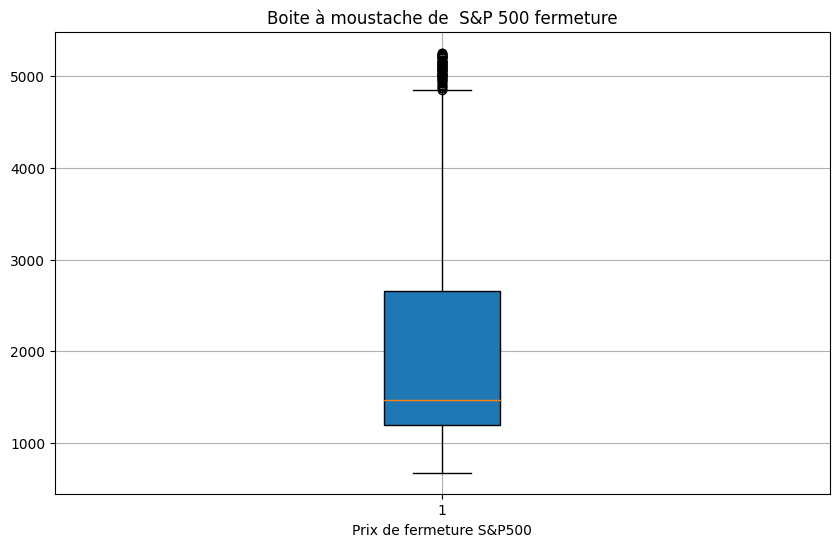

In [11]:
plt.figure(figsize=(10, 6))
plt.boxplot(df.Close, vert=True, patch_artist=True)
plt.title('Boite à moustache de  S&P 500 fermeture')
plt.xlabel('Prix de fermeture S&P500')
plt.grid(True)
plt.show()

**Il y a des données aberentes donc nous les traitons avec la methode d'interpolation linéaire**

In [12]:
for i in df.columns:
    dt=np.array(df[i])
    Q1=np.percentile(dt,25)
    Q3=np.percentile(dt,75)
    IQ=Q3-Q1
    upper=Q3+1.5*IQ
    lower=Q1-1.5*IQ

    dt[(dt[:]>upper) | (dt[:]<lower)]=np.nan
    df[i]=dt

<ipython-input-12-7d811ab9dae2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=dt


In [13]:
df.isna().sum()

Close    69
dtype: int64

In [14]:
# par la methode d'interpolation linéaire
df=df.interpolate(method='linear', axis=0)
df.isna().sum()

Close    0
dtype: int64

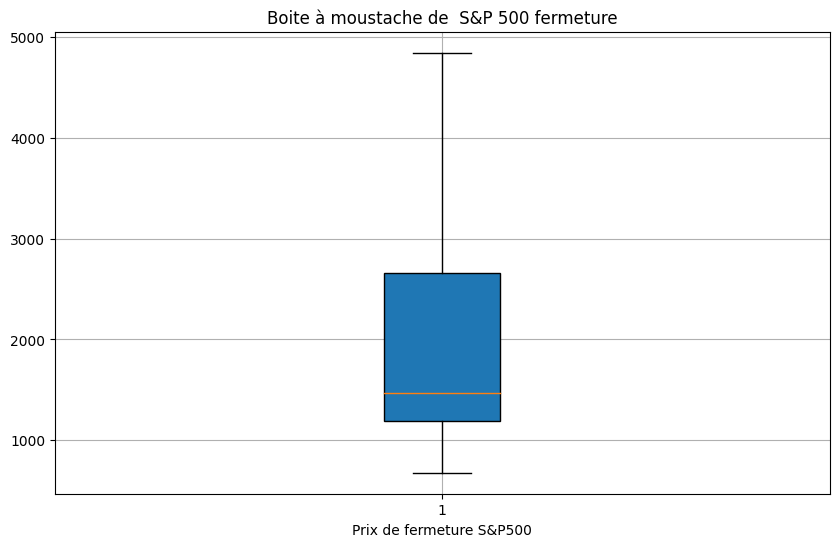

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot(df.Close, vert=True, patch_artist=True)
plt.title('Boite à moustache de  S&P 500 fermeture')
plt.xlabel('Prix de fermeture S&P500')
plt.grid(True)
plt.show()

Le graphique ci-dessus montre que nous avons reglé le problème des outliers

<ipython-input-16-4486192aaf72>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Close'])


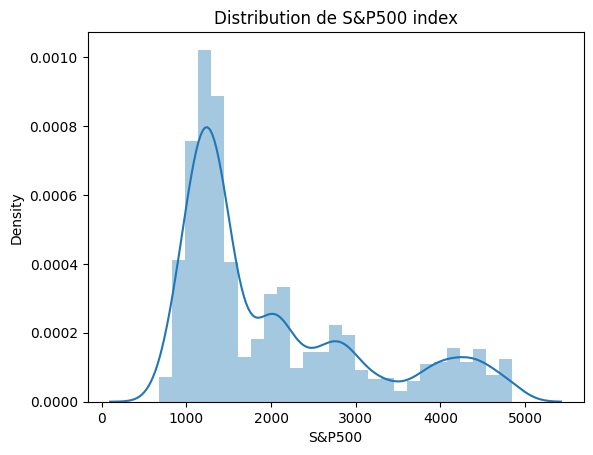

In [16]:
import seaborn as sns
plt.title('Distribution de S&P500 index')
sns.distplot(df['Close'])
plt.xlabel('S&P500')
plt.show()

Notre série ne suis pas une loi normal

# **Modélisation**

- test de stationnarité de ADF

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss


In [18]:
def adf_test(series, title=''):
    """Perform ADF test and print the results."""
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary")

In [19]:
adf_test(df['Close'], title='S&P500')

Augmented Dickey-Fuller Test: S&P500
ADF Test Statistic                1.575044
p-value                           0.997781
#Lags Used                       32.000000
Number of Observations Used    6087.000000
Critical Value (1%)              -3.431425
Critical Value (5%)              -2.862015
Critical Value (10%)             -2.567023
Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary


Notre serie n'est pas stationnaire à niveau car il y a présence de racine unitaire

In [20]:
df['sp500_diff'] = df['Close'].diff().dropna()
# Refaire les tests de stationnarité sur la série différenciée
adf_test(df['sp500_diff'], title='S&P500 Differenced')


Augmented Dickey-Fuller Test: S&P500 Differenced
ADF Test Statistic            -1.553379e+01
p-value                        2.203307e-28
#Lags Used                     3.100000e+01
Number of Observations Used    6.087000e+03
Critical Value (1%)           -3.431425e+00
Critical Value (5%)           -2.862015e+00
Critical Value (10%)          -2.567023e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


La serie est maintenant stationnaire en différence première

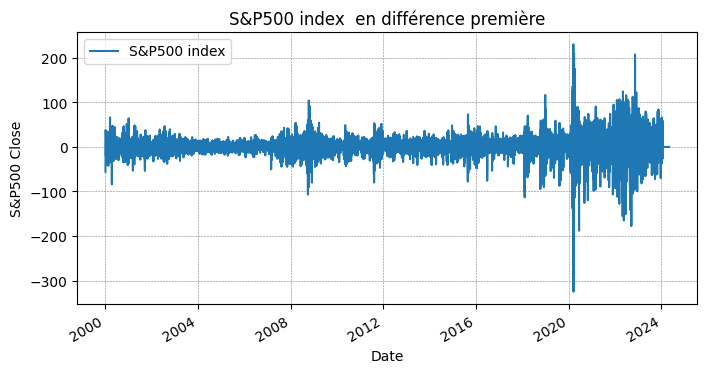

In [21]:
from matplotlib import pyplot as plt
df['sp500_diff'].plot(kind='line', figsize=(8, 4), title='S&P500 index  en différence première',label='S&P500 index')
plt.xlabel('Date')
plt.ylabel('S&P500 Close')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

## Model ARMA

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

Par la suite nous estimons un ARMA(p,1,q) ou p et q à déterminer dans la suite

Etude des ACF et PACF

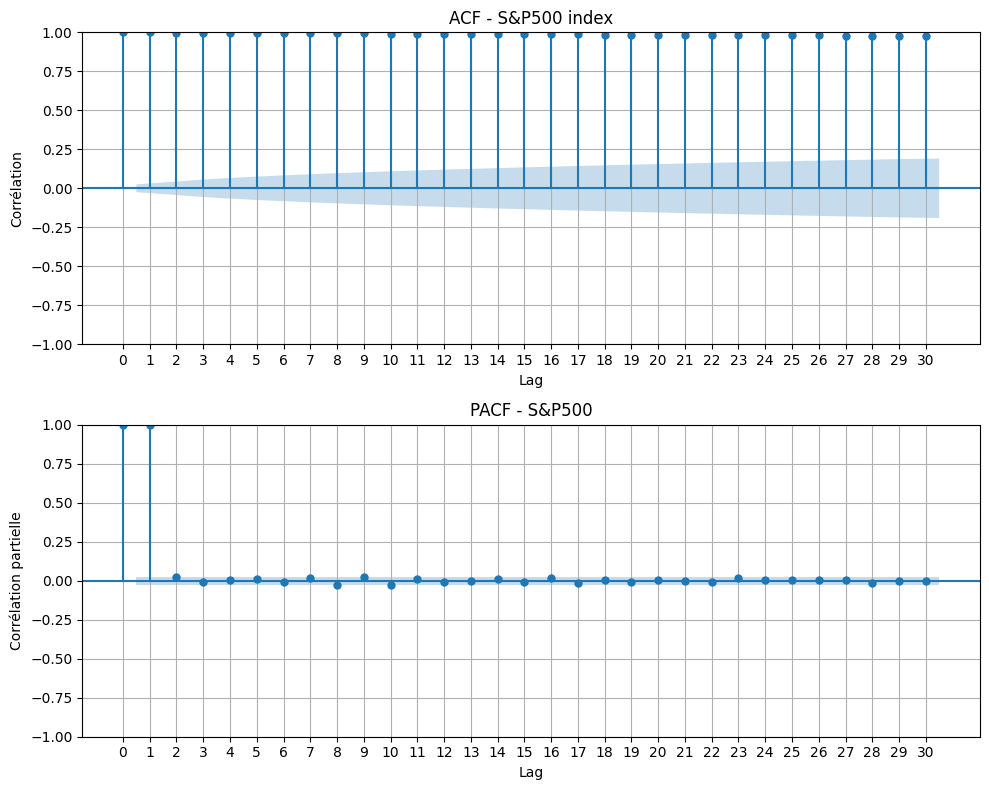

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(df['Close'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - S&P500 index')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(df['Close'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - S&P500')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

In [24]:
# Différenciation pour rendre la série stationnaire
differenced = df['Close'].diff().dropna()

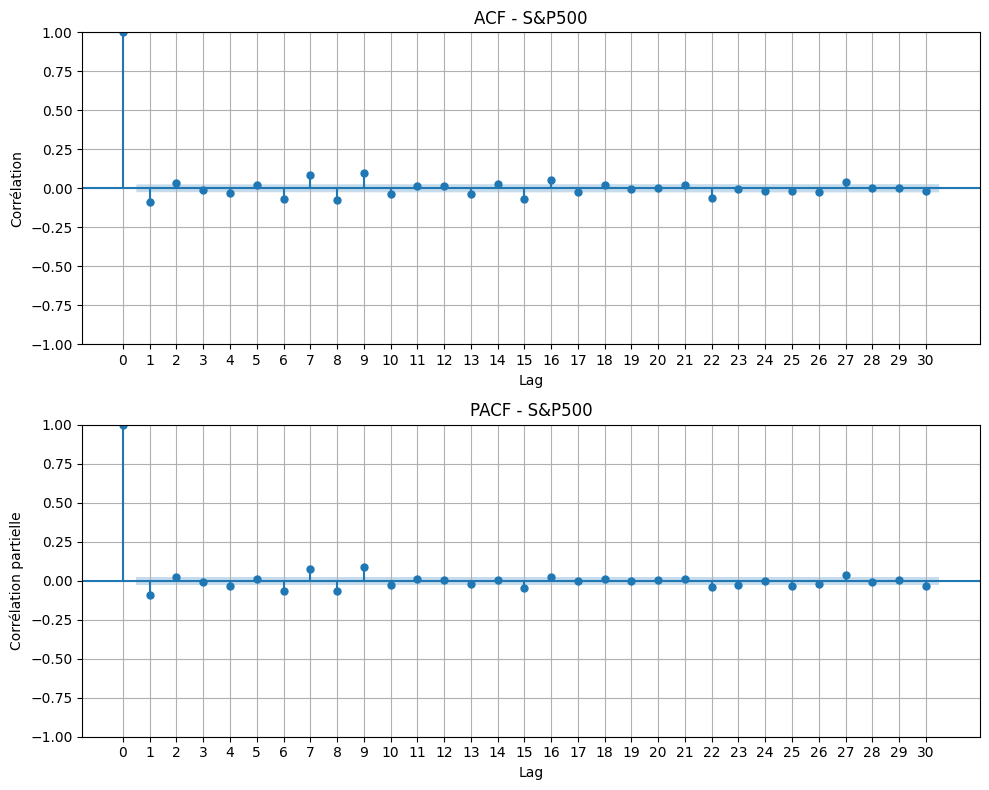

In [25]:
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - S&P500')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - S&P500')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

Estimation du modèle ARMA(p,1,q)

In [26]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


In [35]:
import pandas as pd


# Déterminez la date limite pour l'entraînement (fin de l'année 2020)
trainsize = '2021-11-24'

# Sélectionnez l'index correspondant à la date limite pour l'entraînement
index_limite_entrainement = df.index.searchsorted(pd.to_datetime(trainsize))

# Divisez les données en ensembles d'entraînement et de test
train_data = df.iloc[:index_limite_entrainement]
test_data = df.iloc[index_limite_entrainement:]

# Affichez la taille des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_data))
print("Taille de l'ensemble de test :", len(test_data))

Taille de l'ensemble d'entraînement : 5510
Taille de l'ensemble de test : 610


In [36]:
train_data=train_data['Close']
test_data=test_data['Close']

In [37]:
import pmdarima as pm
# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5510
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -25099.509
Date:                Tue, 28 May 2024   AIC                          50211.019
Time:                        17:29:02   BIC                          50250.703
Sample:                             0   HQIC                         50224.860
                               - 5510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9488      0.005   -195.956      0.000      -0.958      -0.939
ar.L2         -0.6797      0.007    -95.345      0.000      -0.694      -0.666
ar.L3         -0.4829      0.009    -55.661      0.0

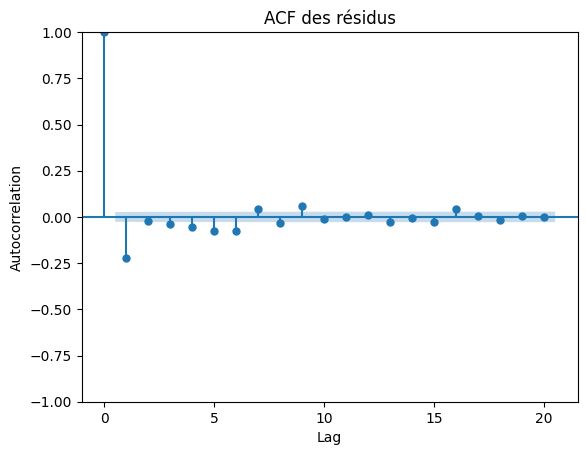

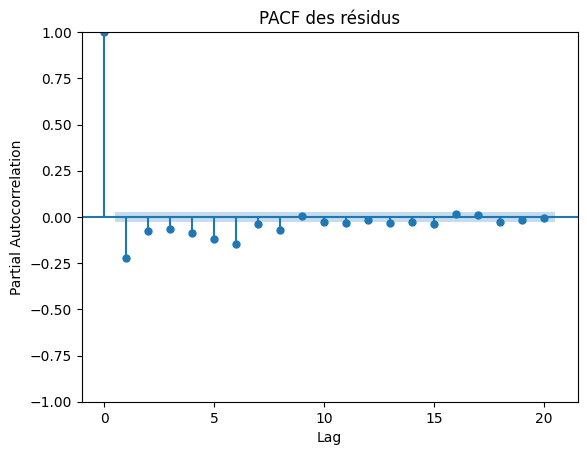

In [38]:
# Ajuster le modèle aux données
model.fit(train_data)
# Obtenir les résidus du modèle
residuals = model.resid()

# Tracer la fonction d'autocorrélation (ACF) des résidus
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF des résidus')
plt.show()

# Tracer la fonction d'autocorrélation partielle (PACF) des résidus
plot_pacf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF des résidus')
plt.show()

In [39]:
# Faire des prédictions sur l'ensemble d'entraînement
train_pred_arma=model.fittedvalues()
model.fit(test_data)
test_pred_arma=model.fittedvalues()

* Evaluation du model ARMA

pour train

In [40]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(train_data, train_pred_arma)
mse = metrics.mean_squared_error(train_data, train_pred_arma)
r2 = np.sqrt(metrics.mean_squared_error(train_data, train_pred_arma))
R2=r2_score(train_data,train_pred_arma)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 14.889033532537573
Mean Square Error: 1027.436100271565
Root Mean Square Error: 32.05364410284055
R2: 0.9985315203993173


- Pour test

In [41]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(test_data, test_pred_arma)
mse = metrics.mean_squared_error(test_data, test_pred_arma)
r2 = np.sqrt(metrics.mean_squared_error(test_data, test_pred_arma))
R2=r2_score(test_data,test_pred_arma)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 48.494515999382735
Mean Square Error: 48775.11761383985
Root Mean Square Error: 220.85089452804996
R2: 0.5865870833195592


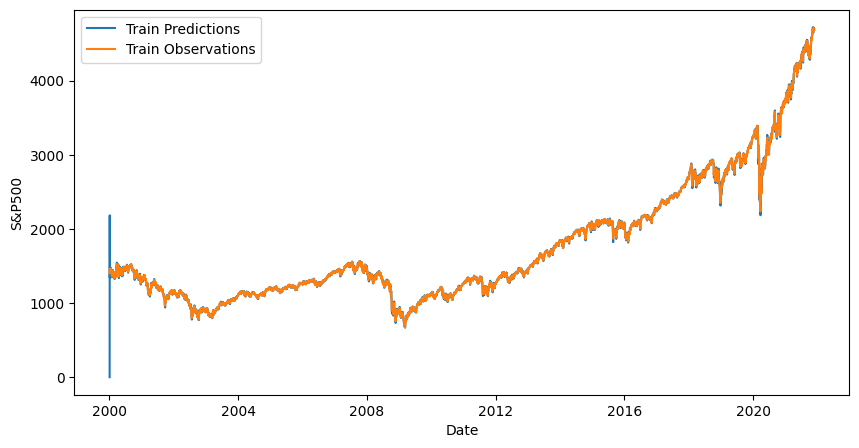

In [42]:
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_pred_arma)
plt.plot(train_data.index, train_data)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Train Predictions', 'Train Observations'])

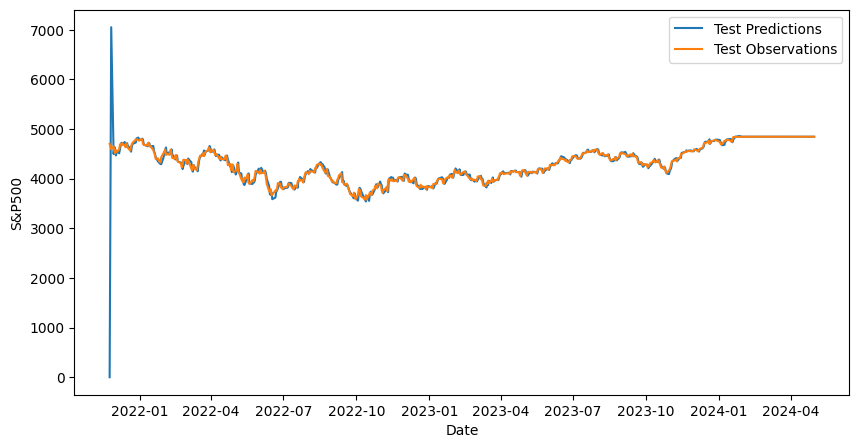

In [43]:
plt.figure(figsize=(10,5))
plt.plot(test_data.index, test_pred_arma)
plt.plot(test_data.index, test_data)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Test Predictions', 'Test Observations'])

# **Partie machine learning**

## 1- division de l'échantillons en trois parties (train, validation et test)

In [44]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2000-01-03')
datetime_object

datetime.datetime(2000, 1, 3, 0, 0)

In [45]:
df=snp500_data[['Close']]
df

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2024-04-24,5071.629883
2024-04-25,5048.419922
2024-04-26,5099.959961


In [46]:
df=df.reset_index()
df=df[['Date','Close']]

In [47]:
df['Date'] = pd.to_datetime(df['Date'])

In [48]:
import datetime

def str_to_datetime(s):
    if isinstance(s, str):
        split = s.split('-')
        year, month, day = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(year=year, month=month, day=day)
    return s

# Apply the custom function only to string formatted dates
df['Date'] = df['Date'].apply(str_to_datetime)

# Ensure the column is of datetime type
df['Date'] = pd.to_datetime(df['Date'])

print(df['Date'].head())


0   2000-01-03
1   2000-01-04
2   2000-01-05
3   2000-01-06
4   2000-01-07
Name: Date, dtype: datetime64[ns]


In [49]:
df.index = df.pop('Date')
df

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2024-04-24,5071.629883
2024-04-25,5048.419922
2024-04-26,5099.959961


In [50]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=7):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2000-02-03',
                                '2024-04-30',
                                n=7)
windowed_df

,Target Date,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2000-02-03,1410.030029,1404.089966,1398.560059,1360.160034,1394.459961,1409.280029,1409.119995,1424.969971
1,2000-02-04,1404.089966,1398.560059,1360.160034,1394.459961,1409.280029,1409.119995,1424.969971,1424.369995
2,2000-02-07,1398.560059,1360.160034,1394.459961,1409.280029,1409.119995,1424.969971,1424.369995,1424.239990
3,2000-02-08,1360.160034,1394.459961,1409.280029,1409.119995,1424.969971,1424.369995,1424.239990,1441.719971
4,2000-02-09,1394.459961,1409.280029,1409.119995,1424.969971,1424.369995,1424.239990,1441.719971,1411.709961
...,...,...,...,...,...,...,...,...,...
6093,2024-04-24,5061.819824,5051.410156,5022.209961,5011.120117,4967.229980,5010.600098,5070.549805,5071.629883
6094,2024-04-25,5051.410156,5022.209961,5011.120117,4967.229980,5010.600098,5070.549805,5071.629883,5048.419922
6095,2024-04-26,5022.209961,5011.120117,4967.229980,5010.600098,5070.549805,5071.629883,5048.419922,5099.959961
6096,2024-04-29,5011.120117,4967.229980,5010.600098,5070.549805,5071.629883,5048.419922,5099.959961,5116.169922


In [51]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((6098,), (6098, 7, 1), (6098,))

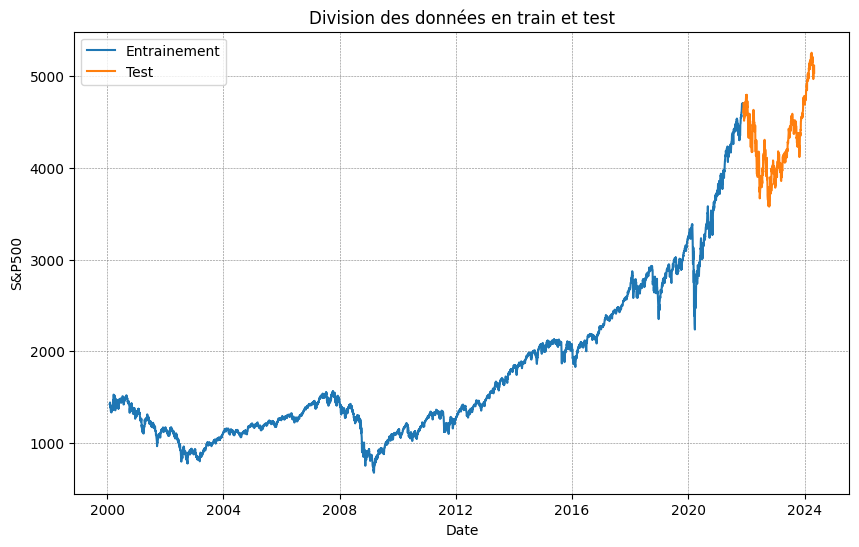

In [53]:
q_90 = int(len(dates) * .9)


dates_train, X_train, y_train = dates[:q_90], X[:q_90], y[:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
plt.figure(figsize=(10,6))
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)
plt.title('Division des données en train et test')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Entrainement', 'Test'])

# Construction du modèle LSTM

In [54]:
from sklearn.preprocessing import MinMaxScaler

# Création des scalers pour X et y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalisation de X_train et X_test
X_train_scal = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scal = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Normalisation de y_train et y_test
y_train_scal = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test_scal = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train_scal, y_train_scal, validation_data=(X_test_scal, y_test_scal), epochs=100)

Epoch 1/100
172/172 [==============================] - 5s 12ms/step - loss: 0.0185 - mean_absolute_error: 0.0612 - val_loss: 6.1958e-04 - val_mean_absolute_error: 0.0199
Epoch 2/100
172/172 [==============================] - 1s 7ms/step - loss: 9.5607e-05 - mean_absolute_error: 0.0066 - val_loss: 5.4793e-04 - val_mean_absolute_error: 0.0187
Epoch 3/100
172/172 [==============================] - 1s 7ms/step - loss: 1.1203e-04 - mean_absolute_error: 0.0073 - val_loss: 6.9391e-04 - val_mean_absolute_error: 0.0219
Epoch 4/100
172/172 [==============================] - 1s 6ms/step - loss: 8.4974e-05 - mean_absolute_error: 0.0063 - val_loss: 7.3023e-04 - val_mean_absolute_error: 0.0226
Epoch 5/100
172/172 [==============================] - 1s 8ms/step - loss: 8.8570e-05 - mean_absolute_error: 0.0065 - val_loss: 4.4840e-04 - val_mean_absolute_error: 0.0168
Epoch 6/100
172/172 [==============================] - 2s 10ms/step - loss: 9.6089e-05 - mean_absolute_error: 0.0069 - val_loss: 7.0839e-0

172/172 [==============================] - 1s 4ms/step


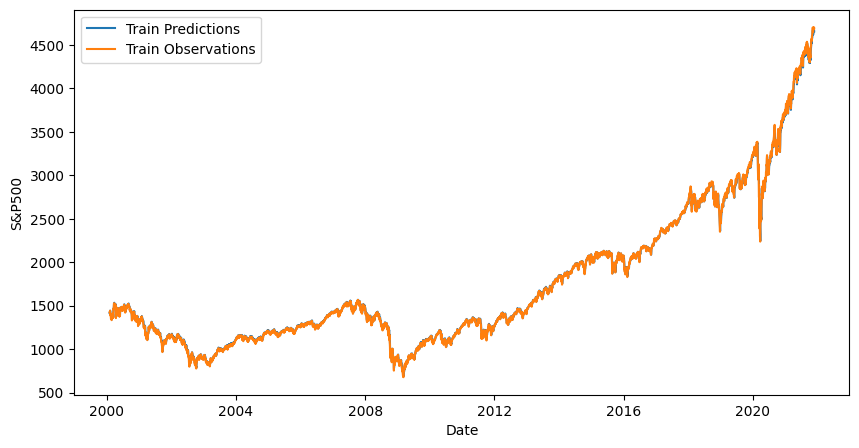

In [56]:
train_predictions_lstm = model.predict(X_train_scal).flatten()
train_predictions_lstm_res = scaler_y.inverse_transform(train_predictions_lstm.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_train, train_predictions_lstm_res)
plt.plot(dates_train, y_train)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Train Predictions', 'Train Observations'])

20/20 [==============================] - 0s 3ms/step


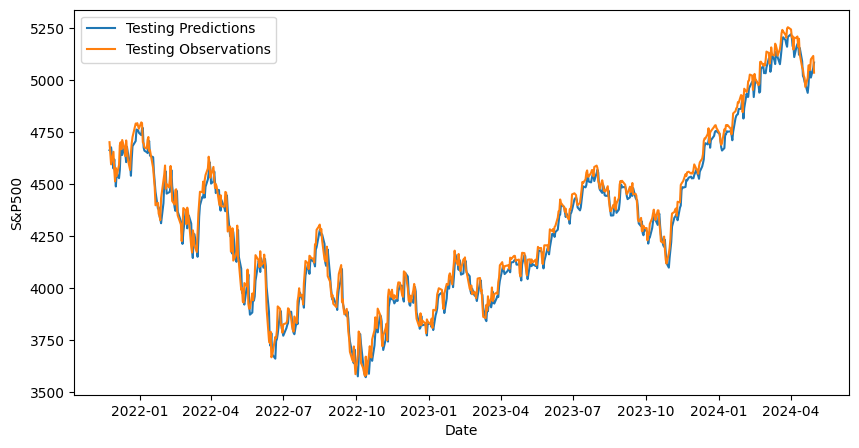

In [57]:
test_predictions_lstm = model.predict(X_test_scal).flatten()
test_predictions_lstm_res=scaler_y.inverse_transform(test_predictions_lstm.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_predictions_lstm_res)
plt.plot(dates_test, y_test)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Testing Predictions', 'Testing Observations'])

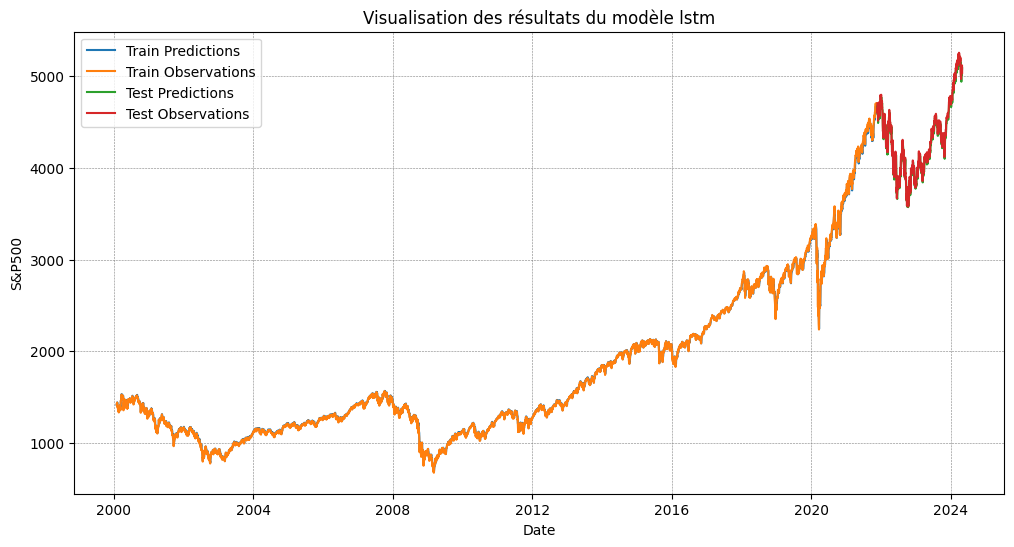

In [58]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions_lstm_res)
plt.plot(dates_train, y_train)
plt.plot(dates_test, test_predictions_lstm_res)
plt.plot(dates_test, y_test)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.title('Visualisation des résultats du modèle lstm')
plt.legend(['Train Predictions',
            'Train Observations',
            'Test Predictions',
            'Test Observations'])

* Evaluation du modèle lstm

- Pour train

In [59]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_train_scal, train_predictions_lstm)
mse = metrics.mean_squared_error(y_train_scal, train_predictions_lstm)
r2 = np.sqrt(metrics.mean_squared_error(y_train_scal, train_predictions_lstm))
R2=r2_score(y_train_scal,train_predictions_lstm)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.0035543726
Mean Square Error: 3.0593168e-05
Root Mean Square Error: 0.005531109
R2: 0.9992929297119598


- pour test

In [60]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_test_scal, test_predictions_lstm)
mse = metrics.mean_squared_error(y_test_scal, test_predictions_lstm)
r2 = np.sqrt(metrics.mean_squared_error(y_test_scal, test_predictions_lstm))
R2=r2_score(y_test_scal,test_predictions_lstm)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.0106153125
Mean Square Error: 0.00017972484
Root Mean Square Error: 0.013406149
R2: 0.9809927210995415


# Model RNN

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Création du modèle RNN
model = Sequential([
    layers.Input((7, 1)),
    layers.SimpleRNN(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])


model.fit(X_train_scal, y_train_scal, validation_data=(X_test_scal, y_test_scal), epochs=100)


Epoch 1/100
172/172 [==============================] - 8s 23ms/step - loss: 0.0121 - mean_absolute_error: 0.0526 - val_loss: 0.0103 - val_mean_absolute_error: 0.0893
Epoch 2/100
172/172 [==============================] - 2s 10ms/step - loss: 1.8166e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356
Epoch 3/100
172/172 [==============================] - 2s 12ms/step - loss: 7.3936e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 4/100
172/172 [==============================] - 2s 12ms/step - loss: 5.6083e-05 - mean_absolute_error: 0.0050 - val_loss: 9.3428e-04 - val_mean_absolute_error: 0.0215
Epoch 5/100
172/172 [==============================] - 2s 11ms/step - loss: 4.8468e-05 - mean_absolute_error: 0.0047 - val_loss: 7.2781e-04 - val_mean_absolute_error: 0.0189
Epoch 6/100
172/172 [==============================] - 2s 13ms/step - loss: 4.6990e-05 - mean_absolute_error: 0.0046 - val_loss: 7.2207e-04 - val_

172/172 [==============================] - 1s 3ms/step


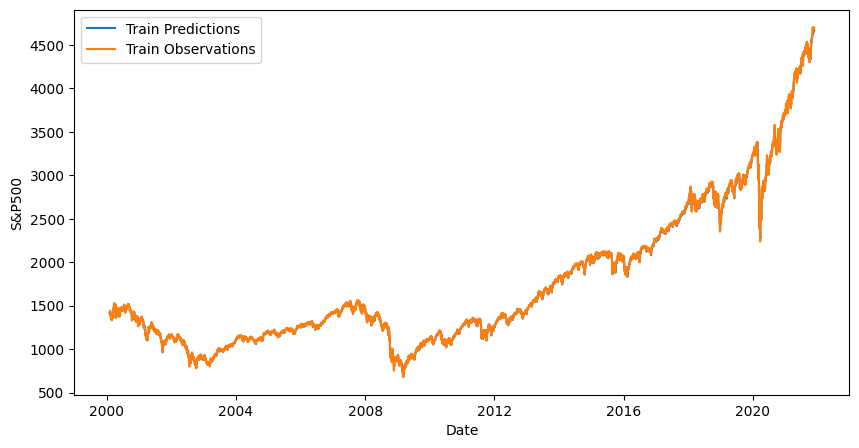

In [63]:
train_predictions_rnn = model.predict(X_train_scal).flatten()
train_predictions_rnn_res=scaler_y.inverse_transform(train_predictions_rnn.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_train, train_predictions_rnn_res)
plt.plot(dates_train, y_train)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Train Predictions', 'Train Observations'])

20/20 [==============================] - 0s 2ms/step


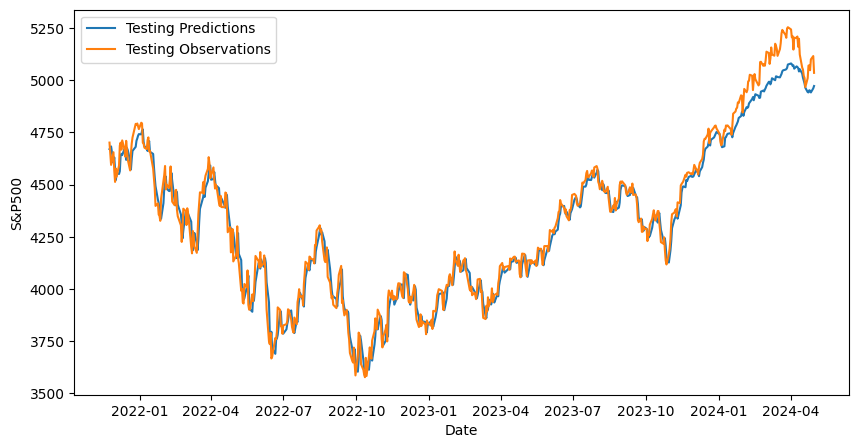

In [64]:
test_predictions_rnn = model.predict(X_test_scal).flatten()
test_predictions_rnn_res=scaler_y.inverse_transform(test_predictions_rnn.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_predictions_rnn_res)
plt.plot(dates_test, y_test)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Testing Predictions', 'Testing Observations'])

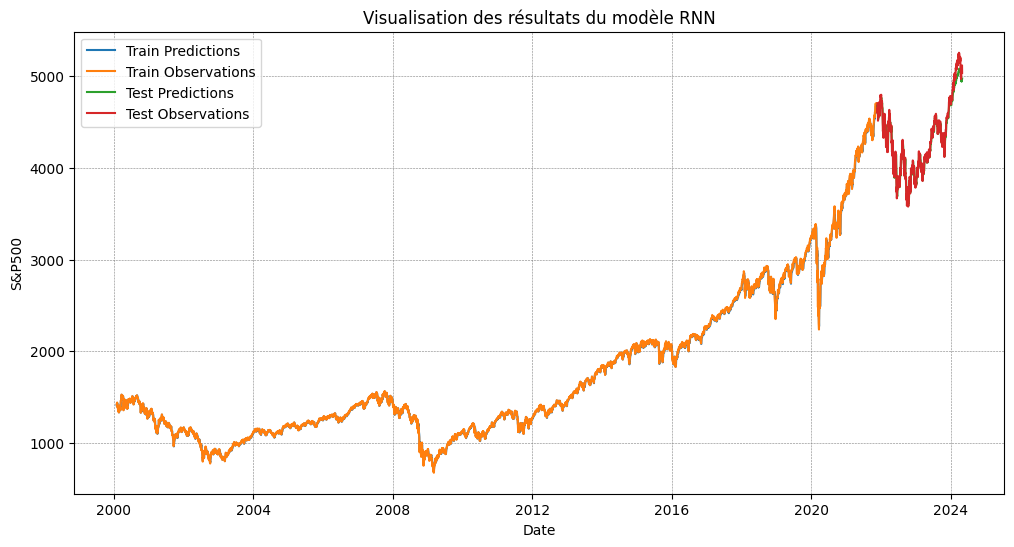

In [65]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions_rnn_res)
plt.plot(dates_train, y_train)
plt.plot(dates_test, test_predictions_rnn_res)
plt.plot(dates_test, y_test)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.title('Visualisation des résultats du modèle RNN')
plt.legend(['Train Predictions',
            'Train Observations',
            'Test Predictions',
            'Test Observations'])

**Evaluation du modèle**

- pour train

In [66]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_train_scal, train_predictions_rnn)
mse = metrics.mean_squared_error(y_train_scal, train_predictions_rnn)
r2 = np.sqrt(metrics.mean_squared_error(y_train_scal, train_predictions_rnn))
R2=r2_score(y_train_scal,train_predictions_rnn)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.0035756177
Mean Square Error: 2.9312368e-05
Root Mean Square Error: 0.0054140897
R2: 0.9993225315904836


- pour test

In [67]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_test_scal, test_predictions_rnn)
mse = metrics.mean_squared_error(y_test_scal, test_predictions_rnn)
r2 = np.sqrt(metrics.mean_squared_error(y_test_scal, test_predictions_rnn))
R2=r2_score(y_test_scal,test_predictions_rnn)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.012515208
Mean Square Error: 0.0002571651
Root Mean Square Error: 0.016036369
R2: 0.9728028173042272


# Model GRU

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Création du modèle GRU
model = Sequential([
    layers.Input((7, 1)),
    layers.GRU(64),  # Utilisation de GRU au lieu de LSTM
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compilation du modèle
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Entraînement du modèle
model.fit(X_train_scal, y_train_scal, validation_data=(X_test_scal, y_test_scal), epochs=100)


Epoch 1/100
172/172 [==============================] - 5s 14ms/step - loss: 0.0063 - mean_absolute_error: 0.0281 - val_loss: 4.0443e-04 - val_mean_absolute_error: 0.0157
Epoch 2/100
172/172 [==============================] - 1s 8ms/step - loss: 4.7071e-05 - mean_absolute_error: 0.0046 - val_loss: 3.3059e-04 - val_mean_absolute_error: 0.0140
Epoch 3/100
172/172 [==============================] - 1s 8ms/step - loss: 4.5946e-05 - mean_absolute_error: 0.0045 - val_loss: 2.5993e-04 - val_mean_absolute_error: 0.0124
Epoch 4/100
172/172 [==============================] - 1s 7ms/step - loss: 4.6391e-05 - mean_absolute_error: 0.0046 - val_loss: 2.4278e-04 - val_mean_absolute_error: 0.0126
Epoch 5/100
172/172 [==============================] - 1s 7ms/step - loss: 4.4845e-05 - mean_absolute_error: 0.0045 - val_loss: 2.6776e-04 - val_mean_absolute_error: 0.0126
Epoch 6/100
172/172 [==============================] - 1s 7ms/step - loss: 4.5664e-05 - mean_absolute_error: 0.0045 - val_loss: 2.5894e-04

172/172 [==============================] - 1s 3ms/step


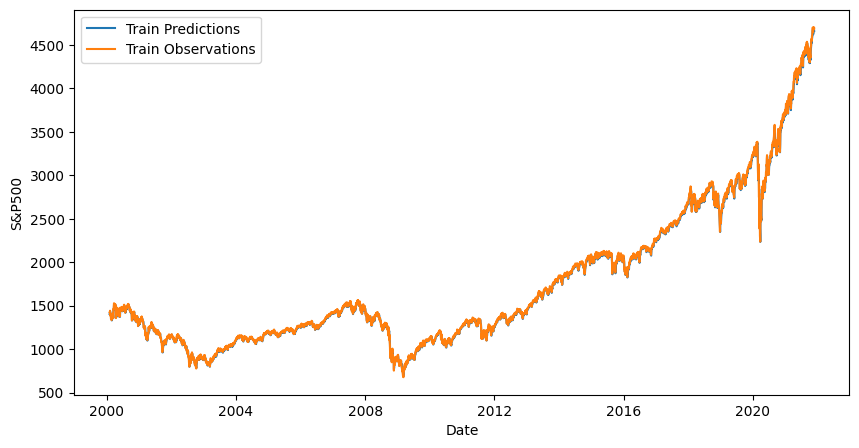

In [69]:
train_predictions_gru = model.predict(X_train_scal).flatten()
train_predictions_gru_res=scaler_y.inverse_transform(train_predictions_gru.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_train, train_predictions_gru_res)
plt.plot(dates_train, y_train)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Train Predictions', 'Train Observations'])

20/20 [==============================] - 0s 3ms/step


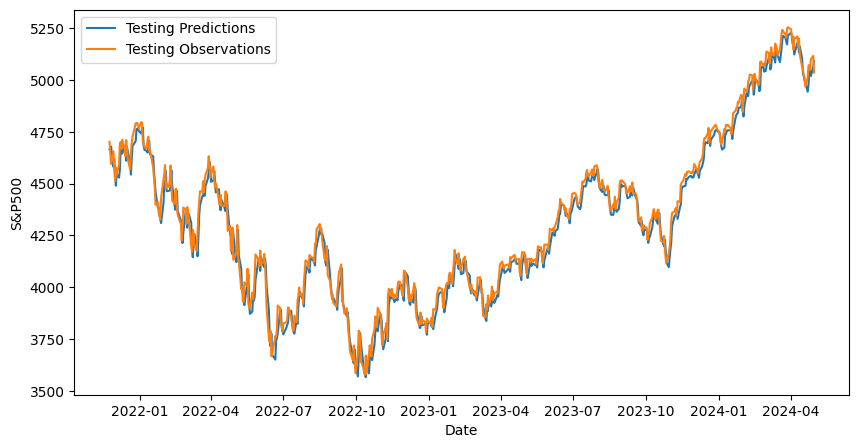

In [70]:
test_predictions_gru = model.predict(X_test_scal).flatten()
test_predictions_gru_res=scaler_y.inverse_transform(test_predictions_gru.reshape(-1, 1)).reshape(-1)
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_predictions_gru_res)
plt.plot(dates_test, y_test)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.legend(['Testing Predictions', 'Testing Observations'])

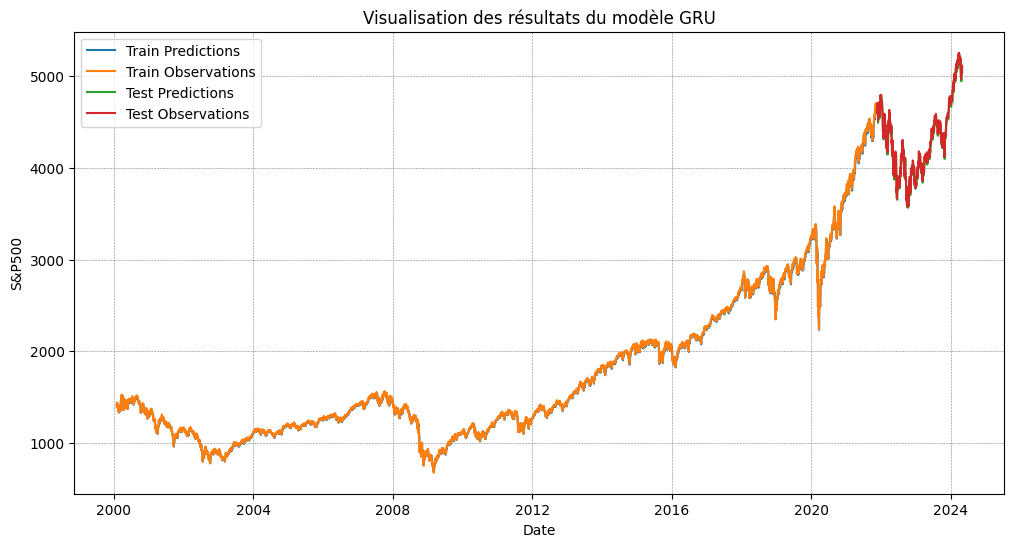

In [71]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions_gru_res)
plt.plot(dates_train, y_train)
plt.plot(dates_test, test_predictions_gru_res)
plt.plot(dates_test, y_test)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.title('Visualisation des résultats du modèle GRU')
plt.legend(['Train Predictions',
            'Train Observations',
            'Test Predictions',
            'Test Observations'])

* Evaluation du modèle GRU

- POUR TRAIN

In [72]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_train_scal, train_predictions_gru)
mse = metrics.mean_squared_error(y_train_scal, train_predictions_gru)
r2 = np.sqrt(metrics.mean_squared_error(y_train_scal, train_predictions_gru))
R2=r2_score(y_train_scal,train_predictions_gru)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.003990896
Mean Square Error: 3.3285996e-05
Root Mean Square Error: 0.005769402
R2: 0.9992306930157354


- pour test

In [73]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = metrics.mean_absolute_error(y_test_scal, test_predictions_gru)
mse = metrics.mean_squared_error(y_test_scal, test_predictions_gru)
r2 = np.sqrt(metrics.mean_squared_error(y_test_scal, test_predictions_gru))
R2=r2_score(y_test_scal,test_predictions_gru)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)
print('R2:', R2)

Mean Absolute Error: 0.010494142
Mean Square Error: 0.00017700504
Root Mean Square Error: 0.013304324
R2: 0.9812803599653293


# Comparaison des modèles

Text(0, 0.5, 'S&P500')

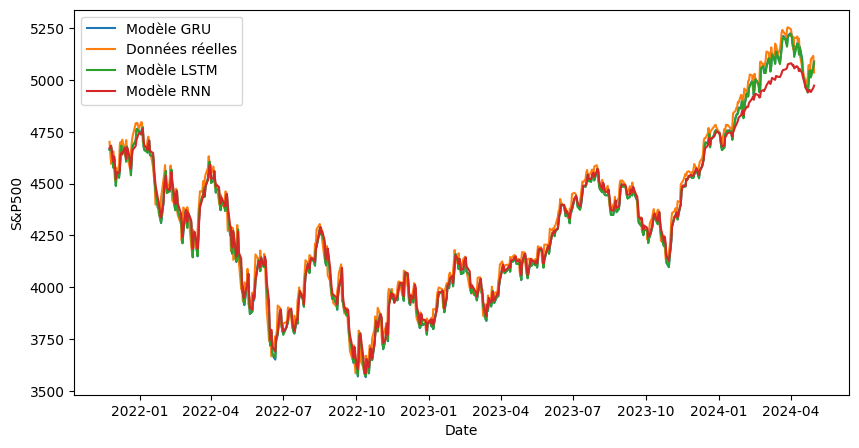

In [74]:
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_predictions_gru_res,label='Modèle GRU')
plt.plot(dates_test, y_test, label='Données réelles')
plt.plot(dates_test,test_predictions_lstm_res, label='Modèle LSTM')
plt.plot(dates_test,test_predictions_rnn_res,label='Modèle RNN')
plt.xlabel('Date')
plt.legend()
plt.ylabel('S&P500')
